# LightGBM baseline model

## Overview

Inspired by [How to get started with Numerai | Kaggle](https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai).

Not using Weights and Biases but using only LightGBM

## Libraries

In [1]:
import os
import random as rn

import lightgbm as lgb
import matplotlib.pyplot as plt

# Initialize Numerai's API
import numerapi
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import spearmanr
from sklearn.model_selection import GridSearchCV

from code import config
from libs.data import download_current_data, load_data
from libs.features import get_group_stats
from libs.libs.metrics import evaluate, sharpe_ratio

In [2]:
napi = numerapi.NumerAPI(verbosity="info")

## Data processing

In [3]:
download_current_data(str(config.DATA_DIR))

train, val, test = load_data(str(config.DATA_DIR), reduce_memory=True)

You already have the newest data! Current round is: 263
Loading the data


## EDA

In [ ]:
test

In [4]:
print("Training data:")
display(train.head(2))
print("Test data:")
display(test.head(2))

Training data:


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.0,0.5,0.25,0.00,0.5,0.25,0.25,...,1.0,1.0,0.75,0.5,0.75,0.50,1.0,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.0,0.0,0.00,0.25,0.5,0.00,0.00,...,1.0,1.0,0.00,0.0,0.75,0.25,0.0,0.25,1.00,0.25


Test data:


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.5,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.0,0.0,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.0,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.5,0.5,0.50


In [5]:
print("Training set info:")
train.info()

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 608.7+ MB


In [6]:
print("Test set info:")
test.info()

Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644415 entries, 0 to 1644414
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 1.9+ GB


In [1]:
test.data_type

NameError: name 'test' is not defined

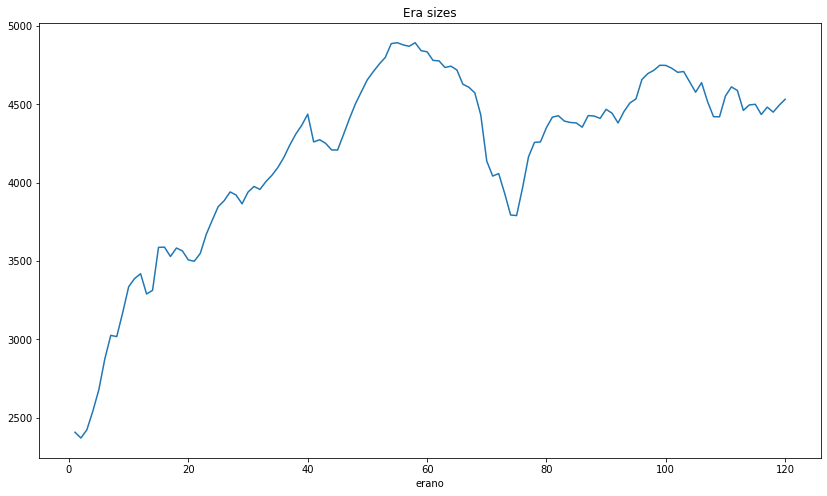

In [7]:
# Extract era numbers
train["erano"] = train.era.str.slice(3).astype(int)
plt.figure(figsize=[14, 6])
train.groupby(train["erano"])["target"].size().plot(
    title="Era sizes", figsize=(14, 8)
);

Eraごとにサンプル数が異なることも考慮して特徴量を作成することができるかもしれない。

In [8]:
feats = [f for f in train.columns if "feature" in f]
pd.DataFrame(train[feats].std()).T

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
0,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.352772,0.353139,0.353139,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419


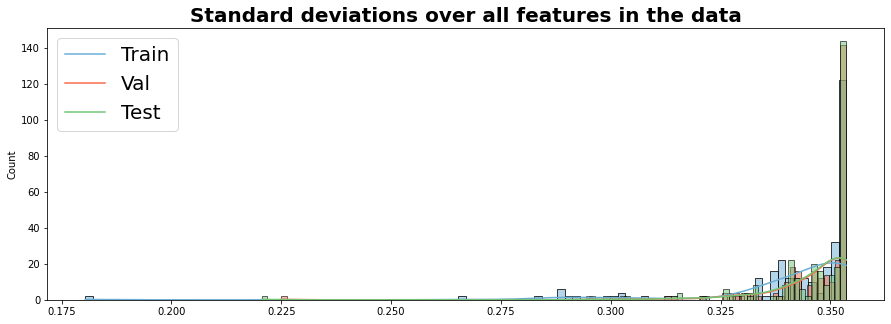

In [9]:
feats = [f for f in train.columns if "feature" in f]
plt.figure(figsize=(15, 5))
sns.histplot(
    pd.DataFrame(train[feats].std()), bins=100, kde=True, palette="Blues"
)
sns.histplot(pd.DataFrame(val[feats].std()), bins=100, kde=True, palette="Reds")
sns.histplot(
    pd.DataFrame(test[feats].std()), bins=100, kde=True, palette="Greens"
)
plt.legend(["Train", "Val", "Test"], fontsize=20)
plt.title(
    "Standard deviations over all features in the data",
    weight="bold",
    fontsize=20,
)
plt.show()

ほとんどの特徴量は同じようなばらつきを持っているが、ごく一部の特徴量はとてもばらつきが小さいのでニューラルネットや回帰系のモデルを使う場合は、標準化や特徴量の削除を考える必要がありそう

## Feature engineering

In [10]:
# Add group statistics features
train = get_group_stats(train)
val = get_group_stats(val)
test = get_group_stats(test)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Feature Selection

特徴量とターゲットの相関係数は一番高いもので、0.01ほどである。
有効な特徴量やera(時点)を見つけることは良いモデルを作成するために大事。

numeraiのデータセットは非定常データであり、特徴量の重要度は時間の経過とともに変わっていく。

そのため、目的変数と説明変数の相関性だけではなく、feature exposure(時間が経過しても、特徴量が予測に役立っていることを表す指標)も考える必要がある。  
PCAなどで次元を削減したり、重要度の高い説明変数のみを抽出することで予測の精度を高めることができる。

In [11]:
# Calculate correlations with target
full_corr = train.corr()
corr_with_target = full_corr["target"].T.apply(abs).sort_values(ascending=False)

# Select features with highest correlation to the target variable
features = corr_with_target[:150]
features.drop("target", inplace=True)

In [12]:
# Create list of most correlated features
feature_list = features.index.tolist()

In [13]:
full_corr.target.apply(abs).sort_values(ascending=False)

target                    1.000000
feature_charisma_mean     0.013717
feature_charisma_skew     0.013131
feature_strength34        0.012310
feature_dexterity7        0.012175
                            ...   
feature_strength37        0.000141
feature_intelligence9     0.000098
erano                     0.000093
feature_constitution23    0.000042
feature_constitution74    0.000007
Name: target, Length: 330, dtype: float64

## Modeling (using LightGBM)

In [14]:
grid_params = {
    "num_leaves": [30, 40, 50],
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "bagging_freq": [7],
    "bagging_fraction": [0.6, 0.7, 0.8],
    "feature_fraction": [0.85, 0.75, 0.65],
}

In [ ]:
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, grid_params, verbose=10, cv=4, n_jobs=-1)

grid.fit(train[feature_list], train["target"])

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


In [20]:
grs = grid.best_estimator_
grs.fit(train[feature_list], train["target"])

train.loc[:, "prediction"] = grs.predict(train[feature_list])
val.loc[:, "prediction"] = grs.predict(val[feature_list])

## Evaluation

In [21]:
# Evaluate Model
print("--- Final Training Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(train)
print("\n--- Final Validation Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(val)

--- Final Training Scores ---
Spearman Correlation: 0.1077
Average Payout: 0.5385
Sharpe Ratio: 3.248
Mean Absolute Error (MAE): 0.1522

--- Final Validation Scores ---
Spearman Correlation: 0.0196
Average Payout: 0.0979
Sharpe Ratio: 0.6809
Mean Absolute Error (MAE): 0.1531


In [24]:
# Calculate feature exposure
all_features = [col for col in train.columns if "feature" in col]
feature_spearman_val = [
    spearmanr(val["prediction"], val[f])[0] for f in all_features
]
feature_exposure_val = np.std(feature_spearman_val).round(4)

## Submission

In [29]:
# Initialize API with API Keys
napi = numerapi.NumerAPI(
    public_id=config.NUMERAI_PUBLIC,
    secret_key=config.NUMERAI_SECRET,
    verbosity="info",
)
# Upload predictions for current round
test.loc[:, "prediction"] = grs.predict(test[feature_list])
test[["id", "prediction"]].to_csv("submission.csv", index=False)

In [31]:
# Upload predictions to Numerai
napi.upload_predictions("submission.csv")

2021-02-13 08:46:57,644 INFO numerapi.base_api: uploading predictions...
2021-02-13 08:48:36,763 ERROR numerapi.base_api: Can't update submission after deadline if previous submission was on time


ValueError: Can't update submission after deadline if previous submission was on time

In [ ]:
print("Submission File:")
test[["id", "prediction"]].head(2)